### Environment Setup: ModelNet & PyTorch3D

This section sets up the environment for 3D point cloud robustness experiments using PyTorch3D and ModelNet.

**Requirements:**
- PyTorch (with CUDA if available)
- PyTorch3D
- tqdm, matplotlib, numpy, pandas, scikit-learn

**Note:** PyTorch3D requires a compatible PyTorch version. See https://pytorch3d.org/docs/installation for details.

In [ ]:
# Install PyTorch3D (uncomment if not already installed)
# For CUDA 11.7 (adjust for your CUDA version):
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

# If you are on CPU-only, use:
# pip install torch torchvision torchaudio
# pip install 'git+https://github.com/facebookresearch/pytorch3d.git'

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
# PyTorch3D
try:
    import pytorch3d
    from pytorch3d.loss import chamfer_distance
    from pytorch3d.ops import sample_points_from_meshes
    print("PyTorch3D is installed and ready.")
except ImportError:
    print("PyTorch3D is not installed. Please follow the instructions above.")

PyTorch3D is installed and ready.


### Step 1: Download and Prepare ModelNet40 Data

We will download the ModelNet40 dataset, extract it, and preprocess it into point clouds.

- The dataset will be stored in a local directory (e.g., `./modelnet40`).
- Each mesh will be sampled into a fixed number of points (e.g., 1024) for use in point cloud classification.
- This step only needs to be run once.

In [2]:
import os
import urllib.request
import zipfile

DATA_DIR = './modelnet40'
MODELNET_URL = 'http://modelnet.cs.princeton.edu/ModelNet40.zip'
ZIP_PATH = os.path.join(DATA_DIR, 'ModelNet40.zip')

# Download ModelNet40 if not present
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(os.path.join(DATA_DIR, 'ModelNet40')):
    print('Downloading ModelNet40...')
    urllib.request.urlretrieve(MODELNET_URL, ZIP_PATH)
    print('Extracting ModelNet40...')
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    print('Done.')
else:
    print('ModelNet40 already downloaded and extracted.')

Extracting ModelNet40...


KeyboardInterrupt: 

### Step 2: Create a PyTorch Dataset and DataLoader for ModelNet40 Point Clouds

This step defines a PyTorch Dataset that loads ModelNet40 meshes, samples point clouds using PyTorch3D, and provides them for training and evaluation.

- Each sample is a tuple: (point_cloud [N, 3], label)
- The dataset supports on-the-fly mesh loading and point sampling.
- You can cache sampled point clouds for faster subsequent runs.

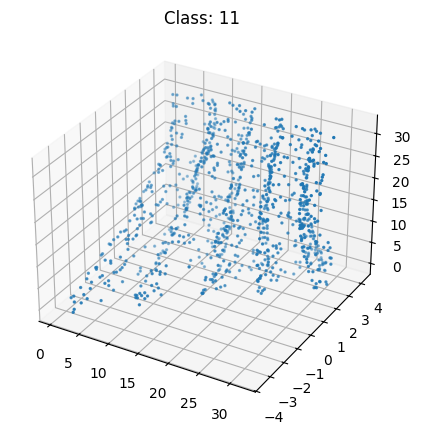

In [6]:
import glob
from torch.utils.data import Dataset, DataLoader
from pytorch3d.structures import Meshes
from pytorch3d.ops import sample_points_from_meshes
import trimesh

class ModelNet40PointCloudDataset(Dataset):
    def __init__(self, root_dir, split='train', num_points=1024, cache=True, random_seed=42):
        self.root_dir = root_dir
        self.split = split
        self.num_points = num_points
        self.cache = cache
        self.random = np.random.RandomState(random_seed)
        self.mesh_paths = []
        self.labels = []
        self.class_map = {}
        self._build_file_list()
        self._cache = {} if cache else None

    def _build_file_list(self):
        classes = sorted(os.listdir(os.path.join(self.root_dir, 'ModelNet40')))
        self.class_map = {cls: i for i, cls in enumerate(classes)}
        for cls in classes:
            split_dir = os.path.join(self.root_dir, 'ModelNet40', cls, self.split)
            if not os.path.exists(split_dir):
                continue
            for off_file in glob.glob(os.path.join(split_dir, '*.off')):
                self.mesh_paths.append(off_file)
                self.labels.append(self.class_map[cls])

    def __len__(self):
        return len(self.mesh_paths)

    def __getitem__(self, idx):
        if self.cache and idx in self._cache:
            return self._cache[idx]
        mesh_path = self.mesh_paths[idx]
        mesh = trimesh.load(mesh_path)
        verts, faces = torch.from_numpy(mesh.vertices).float(), torch.from_numpy(mesh.faces).long()
        mesh = Meshes(verts=[verts], faces=[faces])
        points = sample_points_from_meshes(mesh, self.num_points)[0]  # [N, 3]
        label = self.labels[idx]
        sample = (points, label)
        if self.cache:
            self._cache[idx] = sample
        return sample

train_dataset = ModelNet40PointCloudDataset('./modelnet40', split='train', num_points=1024)
test_dataset = ModelNet40PointCloudDataset('./modelnet40', split='test', num_points=1024)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Visualize a sample point cloud
points, label = train_dataset[0]
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), points[:, 2].cpu(), s=2)
ax.set_title(f'Class: {label}')
plt.show()